In [1]:
# ==============================
# Importing Packages + Functions
# ==============================
import numpy as np
import astropy.io.fits as pf
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def master(image_list, method='mean'):
    if method == 'mean':
        return np.mean(image_list, axis=0)
    if method == 'median':
        return np.median(image_list, axis=0)

### CCD Calibration Formula

The usual bias → dark → flat calibration can be written as:

$$
I_{ij}(\text{obj}) = \frac{ (S_{ij}(\text{obj}) - B_{ij} - D_{ij}) / T_\text{obj} }{ K , (S_{ij}(\text{flat}) - B_{ij}) / T_\text{flat} }
$$

Where each symbol means:

* $S_{ij}(\text{obj})$ — raw science frame (ADU at pixel $(i,j)$)
* $B_{ij}$ — bias frame (master bias image, ADU). This is the zero-exposure electronic offset.
* $D_{ij}$ — dark frame contribution appropriate to the science exposure (master dark, ADU). This should already have the bias removed.
* $T_\text{obj}$ — exposure time of the science frame (seconds). Dividing by $T_\text{obj}$ converts ADU → ADU/sec.
* $S_{ij}(\text{flat})$ — raw flat-field frame (ADU)
* $T_\text{flat}$ — exposure time of the flat (seconds)
* $K$ — scalar chosen so that the flat-field denominator is normalized to mean 1.0 (unitless). Equivalently:

$$
K = \frac{1}{ \langle (S(\text{flat}) - B) / T_\text{flat} \rangle }
$$


In [3]:
# ==============================
# Creating Master Bias, Dark, and Flat
# ==============================
B_list = [pf.getdata(f"AAO/20250312_Bias-00{i}.fit") for i in range(1,8)]
D_list = [pf.getdata(f"AAO/20250312_Dark_5min-00{i}.fit") for i in range(1,8)]
F_list = [pf.getdata(f"AAO/20250403_Twlight_Flat_V-00{i}.fit") for i in range(1,8)]

master_bias = master(B_list)
dark_bs = [d - master_bias for d in D_list]
master_dark = master(dark_bs)
T_dark = 300.0
dark_rate = master_dark / T_dark

master_flat_raw = master([f - master_bias for f in F_list])
T_flat = 4.0
master_flat_rate = master_flat_raw / T_flat
K = 1.0 / np.nanmean(master_flat_rate)
flat_norm = K * master_flat_rate

In [4]:
# ==============================
# Calibrating Image
# ==============================
science_file = "AAO/20250502_M6_V_5min-001.fit"
S_obj = pf.getdata(science_file)
T_obj = pf.getheader(science_file).get('EXPTIME')

S_obj_rate = (S_obj - master_bias) / T_obj
science_corr = S_obj_rate - dark_rate
I_cal = science_corr / flat_norm

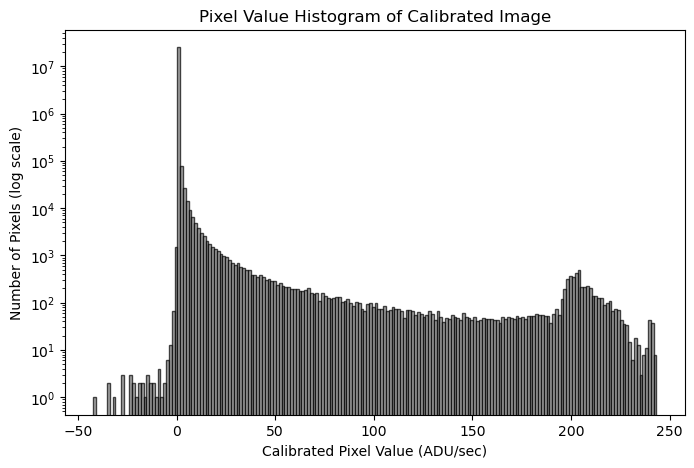

Median pixel value: 0.63 ADU/sec


In [5]:
# ==============================
# Histogram of Calibrated Image (Log Scale)
# ==============================
import matplotlib.pyplot as plt
import numpy as np

pixels = I_cal.flatten()
median_val = np.median(pixels)

plt.figure(figsize=(8,5))
plt.hist(pixels, bins=200, color='gray', alpha=0.7, edgecolor='black', log=True)
plt.xlabel("Calibrated Pixel Value (ADU/sec)")
plt.ylabel("Number of Pixels (log scale)")
plt.title("Pixel Value Histogram of Calibrated Image")
plt.show()

print(f"Median pixel value: {median_val:.2f} ADU/sec")

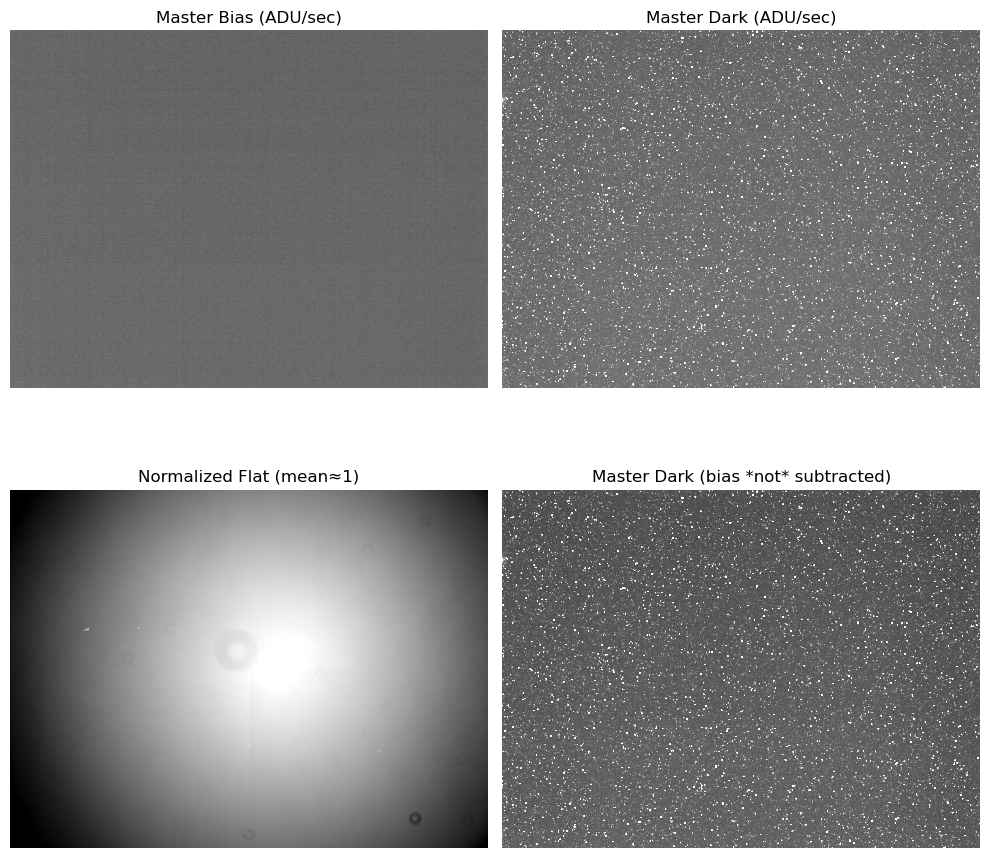

In [6]:
# ==============================
# Visualization of Bias, Dark, Flat
# ==============================
fig, axes = plt.subplots(2,2, figsize=(10,10))
axes = axes.flatten()

def imshow(ax, data, title):
    vmin,vmax = np.percentile(data,[1,99])
    im = ax.imshow(data,cmap='gray',origin='lower',vmin=vmin,vmax=vmax)
    ax.set_title(title,fontsize=12)
    ax.axis('off')
    # plt.colorbar(im,ax=ax,fraction=0.046,pad=0.04)

imshow(axes[0], master_bias/T_obj, "Master Bias (ADU/sec)")
imshow(axes[1], dark_rate, "Master Dark (ADU/sec)")
imshow(axes[2], flat_norm, "Normalized Flat (mean≈1)")

# Disclaimer: the next subplot shows dark frame *without* bias subtraction – for demonstration only
wrong_dark = master(D_list)
imshow(axes[3], wrong_dark, "Master Dark (bias *not* subtracted)")

plt.tight_layout()
plt.show()

In [7]:
# ==============================
# Animation of Calibrated vs Raw Image
# ==============================
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

frames = [S_obj_rate, I_cal]
titles = ["Original Science Frame","Calibrated Science Frame"]

fig2, ax2 = plt.subplots(figsize=(8,8))
ax2.axis('off')

vmin, vmax = np.percentile(S_obj_rate, [1, 99])
im2 = ax2.imshow(S_obj_rate*0, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
title = ax2.set_title("", fontsize=14)

def update(i):
    idx = i % 2
    im2.set_data(frames[idx])
    title.set_text(titles[idx])
    return [im2, title]

ani = FuncAnimation(fig2, update, frames=4, interval=1500, blit=False, repeat=True)

plt.close(fig2)  # closes the figure so Jupyter doesn’t render it statically
HTML(ani.to_jshtml())

You should observe the following in the processed image:

**Positive outcomes:**

1. The processed image has no “hot pixels” (bright pixels with no corresponding source).

2. The background is much more even.

3. Dust donuts are gone. (+2 points)

**Artifacts to watch for:**

1. Large (∼10 pixels across) dark spots may appear after flat-field correction. These are typically caused by stars present in the twilight flats.

2. Small (a few pixels) dark spots can appear after dark subtraction, possibly due to cosmic ray hits in the dark exposures.

**Solution: +10 points**

Use the **median** instead of the mean when stacking flats and darks to avoid skewing from outlier images. For the purposes of this demonstration, you can use the function at the top and rerun the entire notebook again.
